<h1>Titantic Survival Classifier</h1>
<p>Haley Johnson, SI 370 Homework 5</p>

<ul>
    <li><a href = "https://www.kaggle.com/competitions/titanic/overview">Kaggle Competition</a></li>
    <li><a href = "https://github.com/haleyej/SI_370_homework_5">GitHub Repo</a></li>
</ul>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, accuracy_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
sns.set(style = 'darkgrid', context = 'notebook')

<h2>Exploratory Data Analysis</h2>

In [3]:
df = pd.read_csv("data/train.csv")

<p><b>p class:</b> the passenger's ticket class</p>
<p><b>sibsp:</b> number of siblings / spouses aboard</p>
<p><b>parch:</b> number of parents / children aboard</p>
<p><b>embarked:</b> port where passenger got on the ship</p>
<ul>
    <li><b>c:</b> cherbourg</li>
    <li><b>q:</b> queenstown</li>
    <li><b>s:</b> south hampton</li>
</ul>

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.shape

(891, 12)

In [6]:
df.describe(include = [np.number]).T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [7]:
df.describe(exclude = [np.number]).T

,count,unique,top,freq
Name,891,891,"Braund, Mr. Owen Harris",1
Sex,891,2,male,577
Ticket,891,681,347082,7
Cabin,204,147,B96 B98,4
Embarked,889,3,S,644


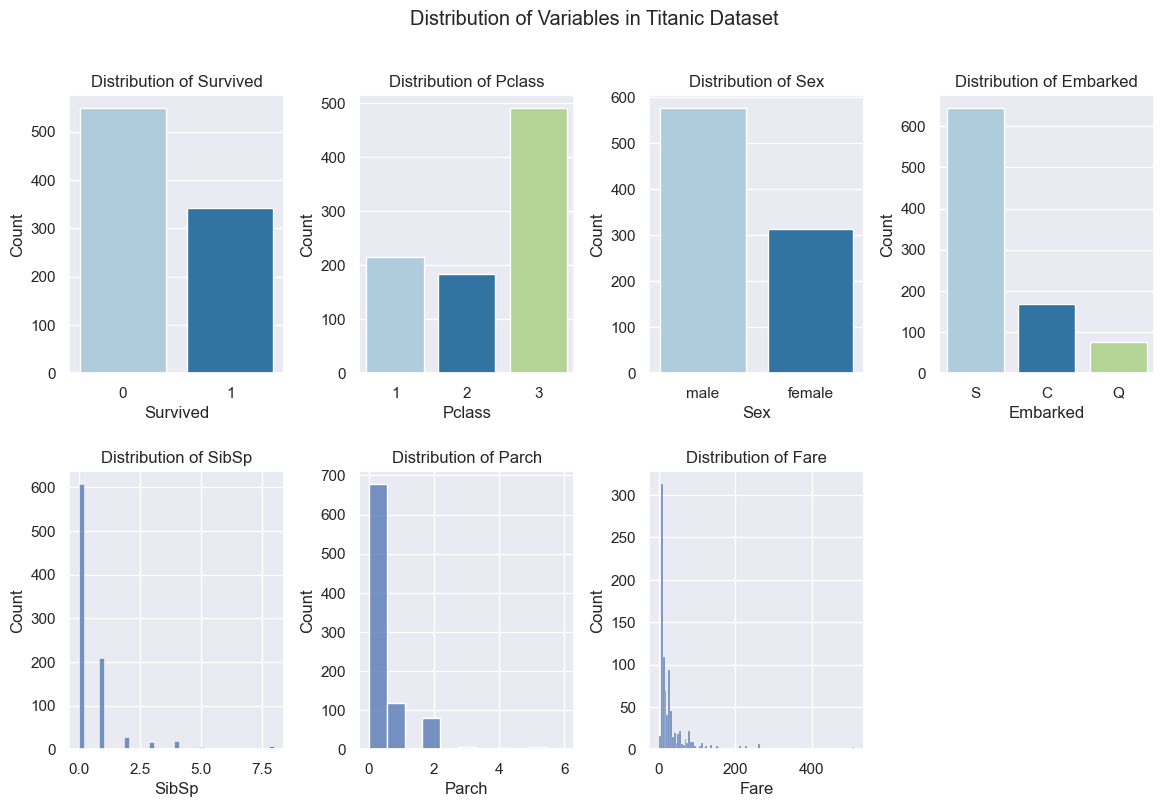

In [8]:
sns.set(rc={'figure.figsize':(14, 8.5)})

categoricals = ['Survived', 'Pclass', 'Sex', 'Embarked']
numerics = ['SibSp', 'Parch', 'Fare']
cols = categoricals + numerics

fig, axes = plt.subplots(2, 4)
axes = axes.flatten()
fig.suptitle('Distribution of Variables in Titanic Dataset')
fig.subplots_adjust(hspace=0.35, wspace=0.35)

for i in range(len(cols)):
    if cols[i] in categoricals:
        sns.countplot(ax = axes[i], x = cols[i], data = df, palette = 'Paired')
        axes[i].set(title = f"Distribution of {cols[i]}", ylabel = 'Count')
    else:
        sns.histplot(ax = axes[i], x = cols[i], data = df)
        axes[i].set(title = f"Distribution of {cols[i]}")

axes[-1].remove()

<h3>Missing Values</h3>

In [9]:
for col in df.columns:
    print(f"Number of missing values in {col}: {pd.isnull(df[col]).sum()}")

Number of missing values in PassengerId: 0
Number of missing values in Survived: 0
Number of missing values in Pclass: 0
Number of missing values in Name: 0
Number of missing values in Sex: 0
Number of missing values in Age: 177
Number of missing values in SibSp: 0
Number of missing values in Parch: 0
Number of missing values in Ticket: 0
Number of missing values in Fare: 0
Number of missing values in Cabin: 687
Number of missing values in Embarked: 2


<p><b>Approach</b>:</p>
<ul>
    <li>Missing values for Age are filled with the mean for the passenger's sex and ticket class</li>
    <li>Missing values for Cabin will not be filled. First, I don't anticipate using this column in my classifier. Secondly, value are missing for 687 out of 891 passengers. It would be difficult to meaningfully fill these values</li>
    <li>The two missing values in Embarked will be filled with the most common location for passengers in their ticket class and sex</li>
<ul>

In [10]:
df['Age'] = df.groupby(["Sex", "Pclass"])['Age'].transform(lambda x: x.fillna(x.mean()))

In [11]:
df[pd.isnull(df.Embarked)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


The most common embarking point for women in first class is South Hamptom

In [12]:
pd.DataFrame(df.groupby(["Sex", "Pclass"])['Embarked'].value_counts())

Embarked
Sex    Pclass Embarked          
female 1      S               48
              C               43
              Q                1
       2      S               67
              C                7
              Q                2
       3      S               88
              Q               33
              C               23
male   1      S               79
              C               42
              Q                1
       2      S               97
              C               10
              Q                1
       3      S              265
              C               43
              Q               39

In [13]:
df['Embarked'] = df['Embarked'].fillna(value = 'S')

In [83]:
#putting all of this in a nice function we can use when it's time to make our final prediction!

def fill_missing_vals(df):
    df['Age'] = df.groupby(["Sex", "Pclass"])['Age'].transform(lambda x: x.fillna(x.mean()))
    df['Embarked'] = df['Embarked'].fillna(value = 'S')
    # get other columns with missing values (for flexibility)
    # we explicitly drop cabin later so no need for it now 
    other_missing = [col for col in df.columns if pd.isnull(df[col]).sum() > 0 and col != 'Cabin']
    for missing in other_missing:
        df[missing] = df.groupby(["Sex", "Pclass"])[missing].transform(lambda x: x.fillna(x.mean()))
    return df

<h2>Feature Engineering</h2>

In [15]:
df['Family Size'] = df['SibSp'] + df['Parch'] 

In [16]:
df['Family Size'].describe()

count    891.000000
mean       0.904602
std        1.613459
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       10.000000
Name: Family Size, dtype: float64

In [17]:
df['Title'] = df.Name.str.extract('([A-Za-z]+)\.', expand=True)

In [18]:
df.Title.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

In [19]:
uncommon_titles = {'Dr': 'Mr', 'Rev': 'Mr', 'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Countess': 'Mrs', 
                   'Capt': 'Mr', 'Ms': 'Miss', 'Sir': 'Mr', 'Lady': 'Miss', 'Don': 'Mr', 'Jonkheer': 'Mr', 
                   'Mme': 'Mrs'}

df = df.replace({'Title': uncommon_titles})

In [20]:
df.Title.value_counts()

Mr        538
Miss      186
Mrs       127
Master     40
Name: Title, dtype: int64

In [21]:
#putting all of this in a nice function we can use when it's time to make our final prediction!

def add_features(df):
    df['Family Size'] = df['SibSp'] + df['Parch'] 
    df['Title'] = df.Name.str.extract('([A-Za-z]+)\.', expand=True)
    uncommon_titles = {'Dr': 'Mr', 'Rev': 'Mr', 'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Countess': 'Mrs', 
                   'Capt': 'Mr', 'Ms': 'Miss', 'Sir': 'Mr', 'Lady': 'Miss', 'Don': 'Mr', 'Jonkheer': 'Mr', 
                   'Mme': 'Mrs'}

    df = df.replace({'Title': uncommon_titles})
    return df 

<h2>Preprocess Data</h2>

In [35]:
X = df.drop(columns = ['Survived', 'PassengerId', 'Name', 'Cabin'])
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [23]:
X_train.shape, X_test.shape

((668, 10), (223, 10))

In [24]:
categoricals += ['Title']
numerics += ['Family Size']

pipe = ColumnTransformer([
    ('encode', OneHotEncoder(handle_unknown = 'ignore'), categoricals[1:]), 
    ('scale', StandardScaler(with_mean = False), numerics)
])

X_train_transformed = pipe.fit_transform(X_train)
X_test_transformed = pipe.transform(X_test)

<h2>Logistic Regression</h2>

In [25]:
reg = LogisticRegression(random_state = 42).fit(X_train_transformed, y_train)

In [26]:
pred_test = reg.predict(X_test_transformed)

In [27]:
accuracy_score(y_test, pred_test)

0.8116591928251121

/var/folders/49/3f_15lzd6b57lnzlk4m_9k440000gn/T/ipykernel_68985/3572301529.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  normalized_conf_matrix = conf_matrix / conf_matrix.astype(np.float).sum(axis = 1)[:, np.newaxis]


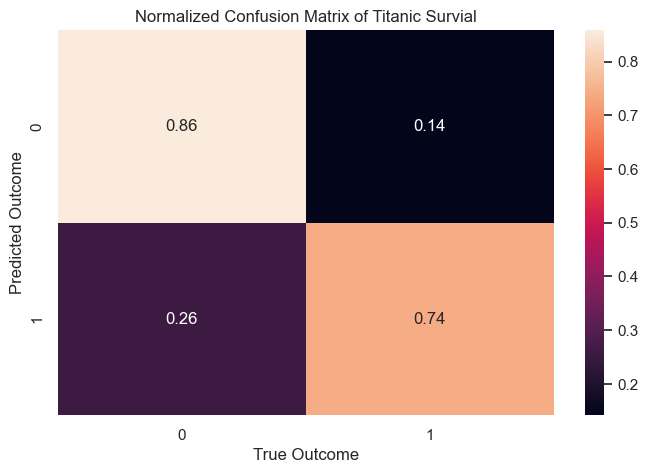

In [28]:
sns.set(rc={'figure.figsize':(8, 5)})

conf_matrix = confusion_matrix(y_test, pred_test)
normalized_conf_matrix = conf_matrix / conf_matrix.astype(np.float).sum(axis = 1)[:, np.newaxis]

f = sns.heatmap(normalized_conf_matrix, annot = True, fmt='.2f', xticklabels = reg.classes_, yticklabels = reg.classes_)
_ = f.set(title = 'Normalized Confusion Matrix of Titanic Survial', ylabel = 'Predicted Outcome', xlabel = 'True Outcome')

<h2>Random Forest Classifier</h2>

In [29]:
n_estimators = {'n_estimators': np.arange(1, 20)}

forest = RandomForestClassifier(criterion = 'entropy', random_state = 42)
n_estimators_search = GridSearchCV(forest, n_estimators, cv = 2, n_jobs = -1)
n_estimators_search.fit(X_train_transformed, y_train)

GridSearchCV(cv=2,
             estimator=RandomForestClassifier(criterion='entropy',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])})

In [30]:
n_estimators_search.best_params_, n_estimators_search.best_score_

({'n_estimators': 6}, 0.8173652694610778)

In [31]:
# commenting out because the output is long and messy, but very important to examinet this!
# n_estimators_search.cv_results_

In [32]:
n_estimators_search.score(X_test_transformed, y_test)

0.7982062780269058

/var/folders/49/3f_15lzd6b57lnzlk4m_9k440000gn/T/ipykernel_68985/2646810015.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  normalized_conf_matrix = conf_matrix / conf_matrix.astype(np.float).sum(axis = 1)[:, np.newaxis]


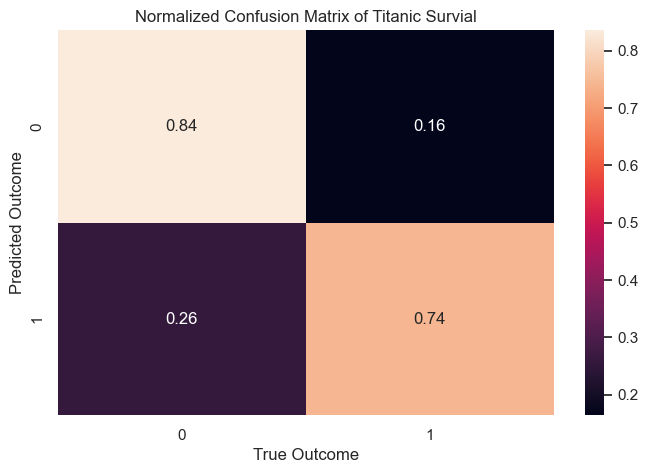

In [33]:
conf_matrix = confusion_matrix(y_test, n_estimators_search.predict(X_test_transformed))
normalized_conf_matrix = conf_matrix / conf_matrix.astype(np.float).sum(axis = 1)[:, np.newaxis]

f = sns.heatmap(normalized_conf_matrix, annot = True, fmt='.2f', xticklabels = reg.classes_, yticklabels = reg.classes_)
_ = f.set(title = 'Normalized Confusion Matrix of Titanic Survial', ylabel = 'Predicted Outcome', xlabel = 'True Outcome')

It seems like adding the title feature was a good idea! Family size, on the other hand, is not very informative

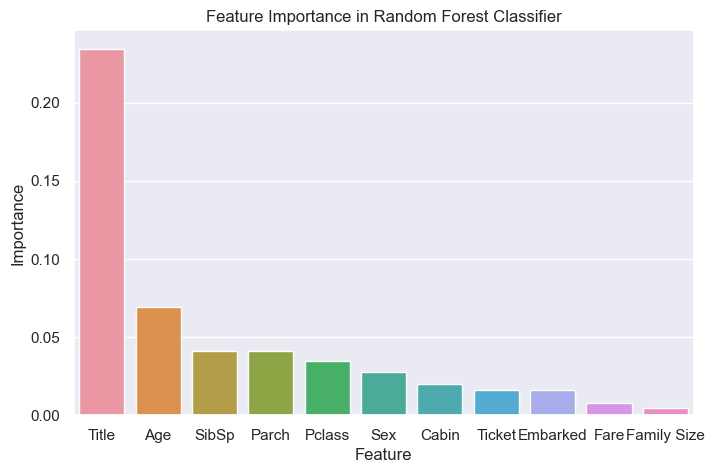

In [37]:
feat_importance = pd.Series(n_estimators_search.best_estimator_.feature_importances_)
feat_importance_df = pd.DataFrame(pd.concat([pd.Series(X_test.columns), feat_importance], axis = 1))
feat_importance_df.columns = ['feature', 'importance']


f = sns.barplot(x = 'feature', y = 'importance', 
                data = feat_importance_df.sort_values(by = 'importance', ascending = False))
_ = f.set(title = 'Feature Importance in Random Forest Classifier', xlabel = 'Feature', ylabel = 'Importance')

<h2>K-Near Neighbors Classifier</h2>

In [38]:
n_neighbors = {'n_neighbors': np.arange(1, 20)}

neighbors = KNeighborsClassifier()
n_neighbors_search = GridSearchCV(neighbors, n_neighbors, cv = 5, n_jobs = -1)
n_neighbors_search.fit(X_train_transformed, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])})

In [39]:
n_neighbors_search.best_params_, n_neighbors_search.best_score_

({'n_neighbors': 12}, 0.8233307148468185)

In [40]:
# commenting out because the output is long and messy, but very important to examine this!
#  n_neighbors_search.cv_results_

In [41]:
n_neighbors_search.score(X_test_transformed, y_test)

0.8026905829596412

In [42]:
knn_results = pd.concat([pd.Series(n_neighbors_search.predict(X_test_transformed)), y_test.reset_index(drop = True)], axis = 1)
knn_results.columns = ['knn_predicted', 'true']

/var/folders/49/3f_15lzd6b57lnzlk4m_9k440000gn/T/ipykernel_68985/2940363200.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  normalized_conf_matrix = conf_matrix / conf_matrix.astype(np.float).sum(axis = 1)[:, np.newaxis]


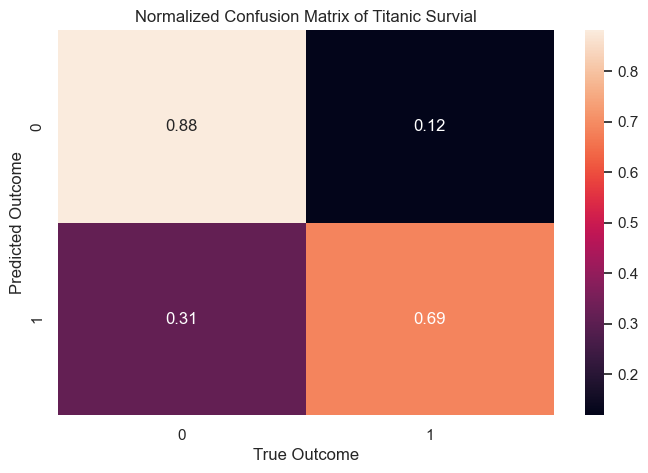

In [43]:
conf_matrix = confusion_matrix(y_test, n_neighbors_search.predict(X_test_transformed))
normalized_conf_matrix = conf_matrix / conf_matrix.astype(np.float).sum(axis = 1)[:, np.newaxis]

f = sns.heatmap(normalized_conf_matrix, annot = True, fmt='.2f', xticklabels = reg.classes_, yticklabels = reg.classes_)
_ = f.set(title = 'Normalized Confusion Matrix of Titanic Survial', ylabel = 'Predicted Outcome', xlabel = 'True Outcome')

<h2>Voting Classifier with Logistic Regression, Random Forest & K-Nearest Neighbors Classifiers</h2>

In [44]:
classifiers = [('random forest', n_estimators_search), ('k-nearest neighbors', n_neighbors_search), 
              ('logistic regression', reg)]

voting = VotingClassifier(classifiers)
voting.fit(X_train_transformed, y_train)

VotingClassifier(estimators=[('random forest',
                              GridSearchCV(cv=2,
                                           estimator=RandomForestClassifier(criterion='entropy',
                                                                            random_state=42),
                                           n_jobs=-1,
                                           param_grid={'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])})),
                             ('k-nearest neighbors',
                              GridSearchCV(cv=5,
                                           estimator=KNeighborsClassifier(),
                                           n_jobs=-1,
                                           param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])})),
                             ('logistic regression',
                              LogisticRegr

In [45]:
voting.score(X_test_transformed, y_test)

0.8026905829596412

The voting classifier aggress with the k-nearest-neighbors classifier in most instances, but they don't always agree

In [46]:
n_neighbors_search.score(X_test_transformed, y_test) == voting.score(X_test_transformed, y_test)

True

In [47]:
voting_results = pd.concat([pd.Series(voting.predict(X_test_transformed)), y_test.reset_index(drop = True)], axis = 1)
voting_results.columns = ['voting_predicted', 'true']

In [48]:
comp = pd.concat([knn_results, voting_results.voting_predicted], axis = 1)
comp[comp.voting_predicted == comp.knn_predicted].shape[0], comp.shape[0]

(219, 223)

In [49]:
comp[comp.voting_predicted != comp.knn_predicted]

,knn_predicted,true,voting_predicted
29,0,0,1
33,0,0,1
50,0,1,1
119,1,0,0


Most errors occur when we predict someone will survive, but they died on the Titanic. Who are these individuals?

/var/folders/49/3f_15lzd6b57lnzlk4m_9k440000gn/T/ipykernel_68985/3758494575.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  normalized_conf_matrix = conf_matrix / conf_matrix.astype(np.float).sum(axis = 1)[:, np.newaxis]


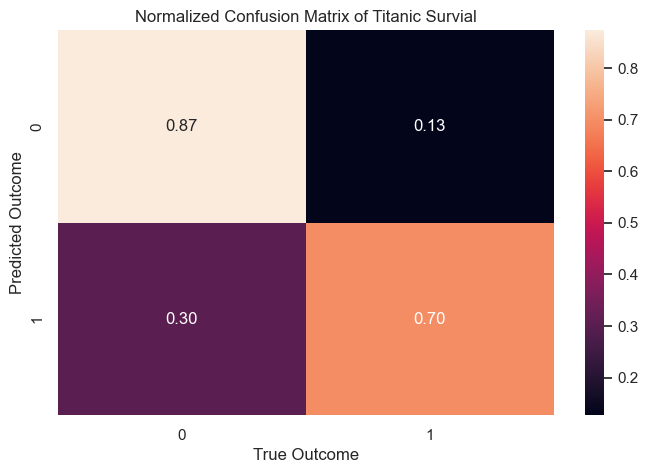

In [50]:
conf_matrix = confusion_matrix(y_test, voting.predict(X_test_transformed))
normalized_conf_matrix = conf_matrix / conf_matrix.astype(np.float).sum(axis = 1)[:, np.newaxis]

f = sns.heatmap(normalized_conf_matrix, annot = True, fmt='.2f', xticklabels = reg.classes_, yticklabels = reg.classes_)
_ = f.set(title = 'Normalized Confusion Matrix of Titanic Survial', ylabel = 'Predicted Outcome', xlabel = 'True Outcome')

<h3>Examining Commonly Misclassified Rows</h3>
Individuals who we predicted would survive, but died

In [51]:
missclassified = pd.concat([X_test.reset_index(drop = True), y_test.reset_index(drop = True), 
                            pd.Series(voting.predict(X_test_transformed))], axis = 1)

missclassified = missclassified.rename(columns = {0 : 'predicted'})
missclassified = missclassified[(missclassified.Survived == 0) & (missclassified.predicted == 1)]

In [52]:
missclassified

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family Size,Title,Survived,predicted
29,3,female,31.000000,0,0,350407,7.8542,NaN,S,0,Miss,0,1
33,3,female,21.750000,0,0,W./C. 6609,7.5500,NaN,S,0,Miss,0,1
44,3,female,45.000000,0,1,2691,14.4542,NaN,C,1,Mrs,0,1
65,2,female,57.000000,0,0,S.O./P.P. 3,10.5000,E77,S,0,Mrs,0,1
70,2,female,26.000000,1,1,250651,26.0000,NaN,S,2,Mrs,0,1
76,3,female,30.500000,0,0,364850,7.7500,NaN,Q,0,Miss,0,1
78,2,female,38.000000,0,0,237671,13.0000,NaN,S,0,Miss,0,1
79,3,female,41.000000,0,2,370129,20.2125,NaN,S,2,Mrs,0,1
114,1,male,41.281386,0,0,PC 17483,221.7792,C95,S,0,Mr,0,1
128,3,female,21.750000,1,0,2689,14.4583,NaN,C,1,Mrs,0,1


<h2>Guassian Naive Bayes Classifier</h2>

In [53]:
nb = GaussianNB()
nb.fit(X_train_transformed, y_train)

GaussianNB()

In [54]:
nb.score(X_test_transformed, y_test)

0.8026905829596412

In [55]:
y_pred = nb.predict(X_test_transformed)

In [56]:
nb_partial_fit = GaussianNB()
nb_partial_fit.partial_fit(X_train_transformed, y_train, y_train.unique())

GaussianNB()

The partially scored Guassian Naive Bayes classifier performs as well as the fully scored version

In [57]:
nb_partial_fit.score(X_test_transformed, y_test)

0.8026905829596412

And both versions are receiving the same accuracy as K-Nearest Neighbors

In [58]:
nb_partial_fit.score(X_test_transformed, y_test) == n_neighbors_search.score(X_test_transformed, y_test)

True

In [59]:
nb.score(X_test_transformed, y_test) == n_neighbors_search.score(X_test_transformed, y_test)

True

The Guassian Naive Bayes Classifier and the K-Nearest Neighbors Classifier are making the same number of errors on the test dataset, but on different examples

In [60]:
nb_results = pd.concat([pd.Series(nb.predict(X_test_transformed)), y_test.reset_index(drop = True)], axis = 1)
nb_results.columns = ['nb_predicted', 'true']

In [61]:
comp = pd.concat([knn_results, nb_results.nb_predicted], axis = 1)
comp[comp.nb_predicted == comp.knn_predicted].shape[0], comp.shape[0]

(209, 223)

In [62]:
comp[comp.nb_predicted != comp.knn_predicted]

,knn_predicted,true,nb_predicted
4,0,1,1
12,0,0,1
22,0,1,1
29,0,0,1
31,0,1,1
33,0,0,1
49,0,0,1
50,0,1,1
133,0,1,1
144,0,0,1


<h2>Voting Classifier with K-Nearest Neighbors and Gaussian Naive Bayes Classifiers</h2>

In [63]:
classifiers = [('k-nearest neighbors', n_neighbors_search), ('naive bayes', nb)]

voting_v2 = VotingClassifier(classifiers)
voting_v2.fit(X_train_transformed, y_train)

VotingClassifier(estimators=[('k-nearest neighbors',
                              GridSearchCV(cv=5,
                                           estimator=KNeighborsClassifier(),
                                           n_jobs=-1,
                                           param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])})),
                             ('naive bayes', GaussianNB())])

In [64]:
voting_v2.score(X_test_transformed, y_test)

0.8026905829596412

In [65]:
voting_v2.score(X_test_transformed, y_test) == voting.score(X_test_transformed, y_test)

True

This classifier is <em>always</em> using the predictions from K-Nearest Neighbors and completely ignorring the Gaussian classifier

In [66]:
voting_v2_results = pd.concat([pd.Series(voting_v2.predict(X_test_transformed)), y_test.reset_index(drop = True)], 
                               axis = 1)
voting_v2_results.columns = ['voting_v2_predicted', 'true']

comp = pd.concat([knn_results, voting_v2_results.voting_v2_predicted], axis = 1)
comp[comp.voting_v2_predicted == comp.knn_predicted].shape[0], comp.shape[0]

(223, 223)

<h2>Voting Classifier with Linear Regression, Random Forest & Gaussian Naive Bayes Classifiers</h2>
<p>Since K-Nearest Neighbors appears to dominate the other two voting classifiers, let's try a version without it to see what results we get</p>

In [67]:
classifiers = [('forest', n_estimators_search), ('naive bayes', nb), ('logistic regression', reg)]

voting_v3 = VotingClassifier(classifiers)
voting_v3.fit(X_train_transformed, y_train)

VotingClassifier(estimators=[('forest',
                              GridSearchCV(cv=2,
                                           estimator=RandomForestClassifier(criterion='entropy',
                                                                            random_state=42),
                                           n_jobs=-1,
                                           param_grid={'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])})),
                             ('naive bayes', GaussianNB()),
                             ('logistic regression',
                              LogisticRegression(random_state=42))])

An improvement!

In [68]:
voting_v3.score(X_test_transformed, y_test)

0.8116591928251121

<h2>Final Predictions</h2>
In the end, I decided to use the last voting classifier I fitted for my predictions

In [84]:
test_df = pd.read_csv("data/test.csv")

In [85]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [87]:
test_df = fill_missing_vals(test_df)
test_df = add_features(test_df)

passenger_ids = test_df.PassengerId
test_df = test_df.drop(columns = ['PassengerId', 'Name'])
test_df = pipe.transform(test_df)

In [96]:
final_predictions = pd.DataFrame(voting_v3.predict(test_df), columns = ['Survived'])
outputs = pd.concat([passenger_ids, final_predictions], axis = 1)

outputs.to_csv("final_predicitions.csv", index = False)